In [30]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Data/macro_features_and_real_oil_prices_log_tranferred_dropped_Nan_skipped_neg_and_zeros_for_log.csv', skiprows=1)
# Drop the "0" column (unnecessary index column)
df = df.drop(columns=['0'])

# 1. Drop columns that contain 50% or more negatives, excluding the first column (index)
cols_to_drop = [col for col in df.columns[1:] if df[col].dtype in ['float64', 'int64'] and (df[col] < 0).mean() >= 0.5]
df = df.drop(columns=cols_to_drop)

# 2. Drop rows that contain any negatives or zeros, excluding the first column
rows_with_neg_or_zero = df[(df[df.columns[1:]].select_dtypes(['float64', 'int64']) <= 0).any(axis=1)].index
df = df.drop(index=rows_with_neg_or_zero)

# Ensure the date column is a datetime type
df['date'] = pd.to_datetime(df['date'])

# Rename columns to meet Prophet's requirements
prophet_df = df.rename(columns={'date': 'ds', 'Real Oil Prices': 'y'})

# Save the dataset
df.to_csv('../../Data/prophet_cleaned_dataset_with_dates.csv', index=False)

df.head()
prophet_df.head()

,ds,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,y
0,1992-02-01,12.962951,12.750812,5.803950,19.534471,17.325209,5.952564,6.137924,6.101171,6.327298,...,5.861682,3.571677,3.772941,3.498251,6.104337,15.967271,17.533756,9.539485,4.091742,13.715729
1,1992-03-01,12.965336,12.751983,5.806582,19.540266,17.320880,5.964607,6.150103,6.113980,6.340179,...,5.865968,3.575312,3.782409,3.500802,6.247928,15.942881,17.542367,9.549875,4.019942,13.601725
2,1992-04-01,12.970718,12.755952,5.807793,19.549848,17.329560,5.975704,6.160908,6.124948,6.353748,...,5.871375,3.580145,3.783457,3.505891,6.270529,15.972082,17.542547,9.562213,4.016897,14.512195
3,1992-05-01,12.978406,12.763876,5.815217,19.537241,17.337448,5.980389,6.168790,6.133329,6.363083,...,5.873100,3.581351,3.783457,3.509696,6.307429,15.924905,17.543025,9.580477,3.880490,15.017895
4,1992-06-01,12.984426,12.770292,5.819106,19.552370,17.341493,5.981250,6.165329,6.128931,6.356100,...,5.875166,3.586164,3.794936,3.512227,6.329124,15.943545,17.556218,9.597480,3.882946,15.981442


11:42:21 - cmdstanpy - INFO - Chain [1] start processing
11:42:21 - cmdstanpy - INFO - Chain [1] done processing


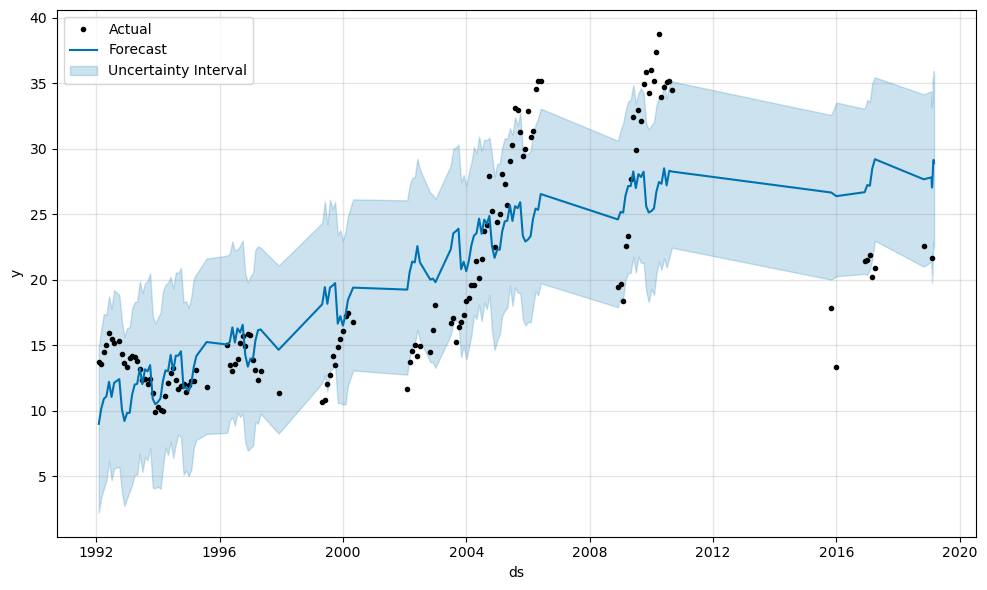

In [21]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit the model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
# Let's say we want to forecast 30 days into the future
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the forecasts
fig = model.plot(forecast)

# Add legend
plt.legend(labels=['Actual', 'Forecast', 'Uncertainty Interval'], loc='upper left')

plt.show()

- Actual: This represents the actual data points from the dataset.
- Forecast: This is the forecasted values generated by the Prophet model for the future dates.
- Uncertainty Interval: This is the confidence interval around the forecasts, indicating the range within which the actual values are likely to fall with a certain level of confidence.

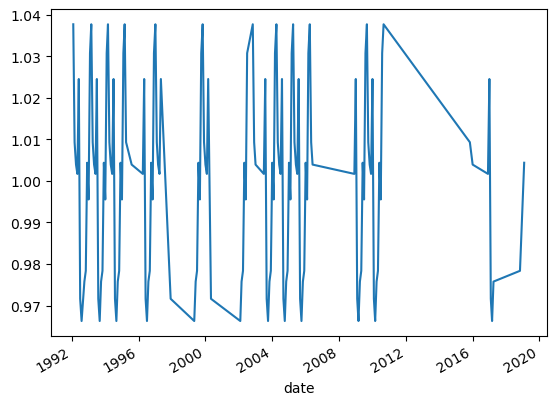

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your data has a yearly seasonality with monthly observations
result = seasonal_decompose(df['Real Oil Prices'], model='multiplicative', period=12)

# Plot the seasonal component
result.seasonal.plot()
plt.show()


The chart you're seeing from the `seasonal_decompose` function represents the seasonal component of your time series data, assuming a multiplicative decomposition model. 
- In a multiplicative time series model, the observed time series is expressed as the product of a trend component, a seasonal component, and an irregular (residual) component.

The y-axis values ranging from 0.97 to 1.04 represent the seasonal factors for each time period in your data. These factors multiply the trend to create the observed data. A seasonal factor of 1 would mean that for that particular time period, the seasonality has no effect (it's neutral). A seasonal factor greater than 1 indicates a positive seasonal effect, while a seasonal factor less than 1 indicates a negative seasonal effect.

Here's how to interpret the seasonal component plot:
1. Seasonal Factor > 1:
    - Values above 1 indicate periods where the data is higher than the trend. This suggests a positive seasonal effect.
2. Seasonal Factor = 1:
    - A value of 1 indicates periods where the data matches the trend. This suggests no seasonal effect.
3. Seasonal Factor < 1:
    - Values below 1 indicate periods where the data is lower than the trend. This suggests a negative seasonal effect.
The x-axis ranging from 1992 to 2020 represents the time span of your data.

The seasonal component plot can help you identify any recurring patterns in your data that happen on a fixed period. For example, if you notice a consistent pattern where the seasonal factor is above 1 every July and below 1 every January, that suggests a yearly seasonal pattern.

If you find clear, repeating patterns in the seasonal component, this information could be useful for forecasting. It might suggest that including seasonality in Prophet model could improve its performance. If the seasonal component looks noisy or doesn't show clear, repeating patterns, that suggests that seasonality may not be a significant factor in your data.

Given my observation of a noisy seasonal component, it's likely that there isn't a strong or clear seasonal pattern in this data, or at least not one at the monthly level as was assumed with a period=12 setting. This is consistent with my earlier intuition about oil prices not having a significant seasonal component. The noisy pattern could also be the result of other factors or noise in the data that aren't accounted for by the seasonal decomposition.

In the context of forecasting with Prophet:
1. Exclude Seasonality:
    - Since the seasonal component appears to be noisy, it might be beneficial to exclude seasonality when fitting the Prophet model, which can done by setting the `yearly_seasonality`, `weekly_seasonality`, and `daily_seasonality` parameters to False.

#### Parameter Tuning - `changepoint_prior_scale` which controls how sensitive the model is to potential changepoints where the trend changes.
- Higher values will make the trend more flexible, lower values will make the trend less flexible.

11:59:18 - cmdstanpy - INFO - Chain [1] start processing
11:59:18 - cmdstanpy - INFO - Chain [1] done processing


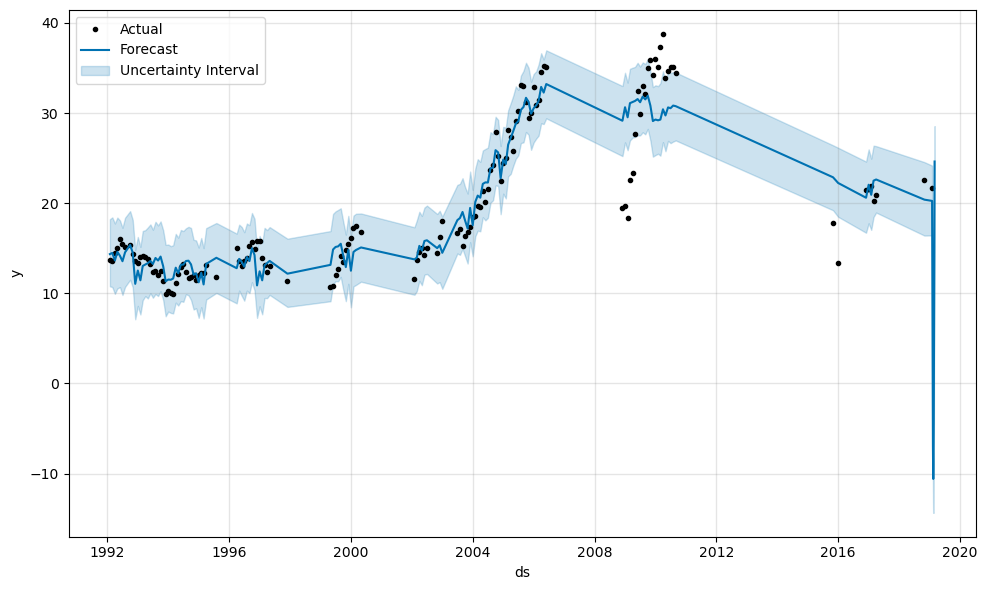

In [41]:
model = Prophet(changepoint_prior_scale=0.5)
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
# Let's say we want to forecast 30 days into the future
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the forecasts
fig = model.plot(forecast)

# Add legend
plt.legend(labels=['Actual', 'Forecast', 'Uncertainty Interval'], loc='upper left')

plt.show()